In [2]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [3]:
import spacy
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from scipy.stats.stats import pearsonr  
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
from utils.categorize_demographics import *
from utils.clean_up import clean_up
from utils.nonnegative_matrix_factorization import nmf_labels, nmf_inspect
from utils.plotting import lollipop_paper
from utils.splits import *
from utils.text_representation import feature_vectors

In [4]:
essay_dict = {'essay0' : 'My self summary',
              'essay1' : 'What I\'m doing with my life',
              'essay2' : 'I\'m really good at',
              'essay3' : 'The first thing people notice about me',
              'essay4' : 'Favorite books, movies, tv, food',
              'essay5' : 'The six things I could never do without',
              'essay6' : 'I spend a lot of time thinking about',
              'essay7' : 'On a typical Friday night I am',
              'essay8' : 'The most private thing I am willing to admit',
              'essay9' : 'You should message me if'}

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [6]:
import seaborn as sns

In [7]:
df = pd.read_csv('data/profiles.csv')
df.columns.values

C:\Users\HP\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education',
       'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'ethnicity', 'height',
       'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes',
       'speaks', 'status'], dtype=object)

In [8]:
must_haves = ['body_type', 'height', 'education', 'ethnicity', 'sex']
print(len(df))
df = df.dropna(subset= must_haves)
print(len(df))

60552
45226


In [9]:
#Keep only men
df= df[df['sex']=="m"]
len(df)

27337

In [10]:
##Recoding the data
# education
ed_levels = {'HS or less': ['dropped out of high school', 'working on high school','graduated from high school', 'working on college/university', 
                    'two-year college', 'dropped out of college/university', 
                    'high school'], 
             'More than HS': ['graduated from college/university', 
                    'working on masters program', 'working on ph.d program', 
                    'college/university', 'working on law school', 
                    'dropped out of masters program', 
                    'dropped out of ph.d program', 'dropped out of law school', 
                    'dropped out of med school',
                    'graduated from masters program',
                    'graduated from ph.d program',                           
                    'graduated from law school', 
                    'graduated from med school', 'masters program', 
                    'ph.d program', 'law school', 'med school']
            }

#body type
bodies = {'average': ['average'], 
          'fit': ['fit', 'athletic', 'jacked'], 
          'thin': ['thin', 'skinny'], 
          'overweight': ['curvey', 'a little extra', 'full figured', 'overweight']
         }

In [11]:
def recode(text, dictionary, default=np.nan):
    '''Function for recoding categories in a column based on exact matches'''
    out = default
    text = str(text)
    
    for x in dictionary.keys():
        for y in dictionary[x]:
            if y == text: #exact match
                out = x
                return out
    return out

In [12]:
df['edu'] = df.education.apply(recode, dictionary=ed_levels, 
                                            default='unknown')
df['body'] = df.body_type.apply(recode, dictionary=bodies, 
                                            default='unknown')

In [13]:
df['height'] = pd.to_numeric(df['height'], errors = 'ignore')

C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


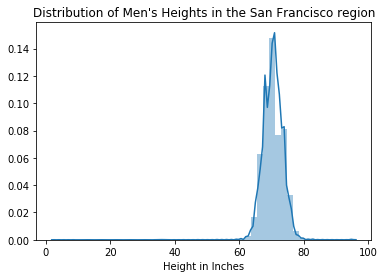

In [14]:
ax = sns.distplot(df['height'], 
                  axlabel= "Height in Inches" ).set_title("Distribution of Men's Heights in the San Francisco region")

In [15]:
print(df)

      age       body_type                 diet      drinks      drugs  \
0      22  a little extra    strictly anything    socially      never   
1      35         average         mostly other       often  sometimes   
3      23            thin           vegetarian    socially        NaN   
4      29        athletic                  NaN    socially      never   
5      29         average      mostly anything    socially        NaN   
9      37        athletic      mostly anything  not at all      never   
11     28         average      mostly anything    socially      never   
16     33             fit                  NaN    socially        NaN   
18     31         average    mostly vegetarian      rarely      never   
19     33        athletic      mostly anything    socially      never   
22     30             fit      mostly anything    socially      never   
23     30            thin       strictly vegan  not at all      never   
24     33            thin    strictly anything    s

[27337 rows x 33 columns]


In [16]:
def height_check(inches):
    h = 'not_short'
    if inches <= 69:
        h = 'short'
    return h

df['height_group'] = df.height.apply(height_check)

In [17]:
df['height'].describe()

count    27337.000000
mean        70.450159
std          3.019595
min          3.000000
25%         68.000000
50%         70.000000
75%         72.000000
max         95.000000
Name: height, dtype: float64

In [20]:
df['essay0']

0        about me:<br />\n<br />\ni would love to think...
1        i am a chef: this is what that means.<br />\n1...
3                i work in a library and go to school. . .
4        hey how's it going? currently vague on the pro...
5        i'm an australian living in san francisco, but...
9        my names jake.<br />\ni'm a creative guy and i...
11       i was born in wisconsin, grew up in iowa, and ...
16       i just moved to the bay area from austin, tx (...
18       some of my favorite things:<br />\nriding my m...
19       i relocated to san francisco half a year ago. ...
22       i tend to think the same way a comedian does a...
23       here's a completely fake summary i wrote while...
24       bay area transplant six years or so now, strai...
25       hey to all, hope all is well and your having a...
26       full-time student, full-time square. i change ...
29       i'm told i can get along with anyone - a produ...
34       i grew up near sacramento, moved to sf for sch.

In [18]:
def word_num(essay):
    all_words = essay.split(' ')
    return len(all_words)

In [24]:
len(df['essay0'][0].split(' '))

219

In [19]:
df['intro_len'] = df['essay0'].apply(word_num)


AttributeError: 'float' object has no attribute 'split'

In [ ]:
df['edu'].describe()

In [ ]:
ax = sns.distplot(df['intro_len'], 
                  axlabel= "Number of Words" ).set_title("Distribution of Length of Men's Self-Description Essays in the San Francisco Region")

In [ ]:
df['intro_len'].describe()

In [ ]:
df.groupby(['height_group']).size()
#df.groupby(['edu']).size()

In [25]:
df_short = df[df['height_group']=="short"]
df_notshort = df[df['height_group']=="not_short"]


In [ ]:
df['essay0']

In [30]:
profile_section_to_use = 'essay0'

In [32]:
# Some of the essays have just a link in the text. BeautifulSoup sees that and gets 
# the wrong idea. This line hides those warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
def clean(text):
    if pd.isnull(text):
        t = np.nan
    else:
        t = BeautifulSoup(text, 'lxml').get_text()
        t = t.lower()

        bad_words = ['http', 'www', '\nnan']

        for b in bad_words:
            t = t.replace(b, '')
    if t == '':
        t = np.nan
    
    return t

In [33]:
profiles= df

In [ ]:
#profiles = df_notshort

In [34]:
print('Cleaning up profile text for', profile_section_to_use, '...')
profiles['clean'] = profiles[profile_section_to_use].progress_apply(clean)

print('We started with', profiles.shape[0], 'profiles.')
print("Dropping profiles that didn't write anything for the essay we chose...")
profiles.dropna(axis=0, subset=['clean'], inplace=True)

text_cols = ['text', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 
             'essay5', 'essay6', 'essay7', 'essay8', 'essay9']
#profiles.drop(columns=text_cols, inplace=True)

#what we will use as our documents, here the cleaned up text of each profile
documents = profiles['clean'].values

print('We have', documents.shape[0], 'profiles left.')

Cleaning up profile text for essay0 ...


100%|██████████████████████████████████████████████████████████████████████████| 27337/27337 [00:20<00:00, 1339.22it/s]


We started with 27337 profiles.
Dropping profiles that didn't write anything for the essay we chose...
We have 25281 profiles left.


In [54]:
documents

array(["about me:\n\ni would love to think that i was some some kind of intellectual:\neither the dumbest smart guy, or the smartest dumb guy. can't say i\ncan tell the difference. i love to talk about ideas and concepts. i\nforge odd metaphors instead of reciting cliches. like the\nsimularities between a friend of mine's house and an underwater\nsalt mine. my favorite word is salt by the way (weird choice i\nknow). to me most things in life are better as metaphors. i seek to\nmake myself a little better everyday, in some productively lazy\nway. got tired of tying my shoes. considered hiring a five year\nold, but would probably have to tie both of our shoes... decided to\nonly wear leather shoes dress shoes.\n\nabout you:\n\nyou love to have really serious, really deep conversations about\nreally silly stuff. you have to be willing to snap me out of a\nlight hearted rant with a kiss. you don't have to be funny, but you\nhave to be able to make me laugh. you should be able to bend spoon

In [40]:
tf_vectorizer = CountVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by word counts...")
tf_text = tf_vectorizer.fit_transform(documents)

tmp = tf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")



Vectorizing text by word counts...
Our transformed text has 25281 rows and 1000 columns.


In [41]:
tf_words = tf_vectorizer.get_feature_names()

print("The first few words (alphabetically) are:\n\n", tf_words[:20])

The first few words (alphabetically) are:

 ['10', '100', '11', '12', '15', '20', '30', 'ability', 'able', 'abroad', 'absolutely', 'act', 'active', 'activities', 'activity', 'actually', 'add', 'admit', 'adventure', 'adventures']


In [ ]:
n = 6

def show_vector(x, words):
    rows,cols = x.nonzero()
    for row,col in zip(rows,cols):
        print(words[col], '\t', x[row,col].round(2))

print('Profile text:\n', documents[n])
print('\nTF (count) vector:')
show_vector(tf_text[n], tf_words)

In [42]:
#how many topics we want our model to find
ntopics = 20

#how many top words we want to display for each topic
nshow = 20

In [43]:
model = LatentDirichletAllocation(n_components=ntopics, max_iter=10, 
                                  learning_method='online', n_jobs=-1)

print('Performing LDA on vectors. This may take a while...')
lda = model.fit(tf_text)
lda_topics = lda.components_

print('Done!')

Performing LDA on vectors. This may take a while...
Done!


In [44]:
pyLDAvis.sklearn.prepare(lda, tf_text, tf_vectorizer)

C:\Users\HP\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.145359 -0.048369       1        1  15.064885
8      0.092044 -0.164277       2        1  13.592356
15     0.185969 -0.062315       3        1   9.923880
7      0.094372 -0.132812       4        1   8.114422
1      0.197109 -0.041270       5        1   7.965351
14     0.115568 -0.096323       6        1   6.829520
0      0.111215  0.081818       7        1   6.217319
9      0.123316 -0.029485       8        1   3.964938
3     -0.268849 -0.197350       9        1   3.766769
6     -0.342890 -0.160563      10        1   3.741922
5      0.106714 -0.067393      11        1   3.567721
19     0.013775  0.067159      12        1   3.238593
11    -0.264024 -0.158414      13        1   2.983368
17     0.043754  0.158676      14        1   2.271586
13     0.036272  0.083583      15        1   2.102159
12     0.001352  0.045266      16        1   1.918347
18    -0.121138  0.076037      17        1   1.637320
10     0.074744  0.120818      18        1   1.525787
16    -0.149308  0.198809      19        1   0.908581
4     -0.195356  0.326406      20        1   0.665177, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
937   Default   7707.000000           ve   7707.000000  30.0000  30.0000
461   Default  11010.000000         just  11010.000000  29.0000  29.0000
471   Default   6885.000000         know   6885.000000  28.0000  28.0000
63    Default   4304.000000          bay   4304.000000  27.0000  27.0000
742   Default   4180.000000          san   4180.000000  26.0000  26.0000
501   Default  12896.000000         life  12896.000000  25.0000  25.0000
994   Default   5624.000000        years   5624.000000  24.0000  24.0000
647   Default  11797.000000       people  11797.000000  23.0000  23.0000
33    Default   3807.000000         area   3807.000000  22.0000  22.0000
596   Default  10092.000000          new  10092.000000  21.0000  21.0000
504   Default  20495.000000         like  20495.000000  20.0000  20.0000
320   Default   3437.000000    francisco   3437.000000  19.0000  19.0000
524   Default   6653.000000      looking   6653.000000  18.0000  18.0000
372   Default   4898.000000          guy   4898.000000  17.0000  17.0000
762   Default   2486.000000        sense   2486.000000  16.0000  16.0000
430   Default   2347.000000           im   2347.000000  15.0000  15.0000
426   Default   2467.000000        humor   2467.000000  14.0000  14.0000
946   Default   4979.000000         want   4979.000000  13.0000  13.0000
580   Default   3744.000000        moved   3744.000000  12.0000  12.0000
329   Default   6190.000000          fun   6190.000000  11.0000  11.0000
260   Default   8001.000000        enjoy   8001.000000  10.0000  10.0000
981   Default   6246.000000         work   6246.000000   9.0000   9.0000
225   Default   7614.000000          don   7614.000000   8.0000   8.0000
354   Default   6107.000000        going   6107.000000   7.0000   7.0000
540   Default   1495.000000        makes   1495.000000   6.0000   6.0000
530   Default  18163.000000         love  18163.000000   5.0000   5.0000
555   Default   3546.000000         meet   3546.000000   4.0000   4.0000
129   Default   3544.000000         city   3544.000000   3.0000   3.0000
356   Default   9820.000000         good   9820.000000   2.0000   2.0000
712   Default   6485.000000       really   6485.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
218   Topic20    117.060223         dive    284.673427   4.1242  -3.9460
809   Topic20    173.552853         soul    535.452720   3.8862  -3.5522
125   Topic20     99.970493        child    317.766440   3.8564  -4.1038
710   Topic20     60.851303      realize    285.671691   3.4665  -4.6002
77    Topic20     51.017028        black    388.235227   2.9834  -4.

In [82]:
topic_labels = ['meet & greet', 'the city', 'enthusiastic', 'straight talk', 'about me', 'novelty',
          'seeking', 'carefree', 'casual', 'enjoy', 'transplant', 'nots', 'moments',
          'personality', 'amusing', 'review', 'region', 'career-focused', 'locals',
          'unconstrained', 'active', 'creative', 'carpe diem', 'cheerful', 'jet setter']

In [57]:
from utils.nonnegative_matrix_factorization import nmf_labels, nmf_inspect

In [51]:
def describe_topic(topic, feature_names, n_words=10):
    words = []
    # sort the words in the topic by importance
    topic = topic.argsort() 
    # select the n_words most important words
    topic = topic[:-n_words - 1:-1]
    # for each important word, get it's name (i.e. the word) from our list of names
    for i in topic:
        words.append(feature_names[i])
    # print the topic number and its most important words, separated by spaces
    return " ".join(words)

def display_topics(components, feature_names, n_words=10):
    # loop through each topic (component) in the model; show its top words
    for topic_idx, topic in enumerate(components):
        print("Topic {}:".format(topic_idx), 
              describe_topic(topic, feature_names, n_words))
    return

def find_intersection(idxa, idxb, n):
    a = set()
    b = set()
    both = set()
    i = 0
    while len(both) < n:
        a.add(idxa[i])
        b.add(idxb[i])
        both = a.intersection(b)
        i += 1
    return list(both)

def compare_topic_words(topics, a, b, words, how='overlap', n_words=nshow):
    b_sort = False
    if how == 'difference':
        b_sort = True
    
    dfa = pd.DataFrame(topics, columns=words).T
    idxa = dfa.sort_values(by=a, ascending=False).index.values
    idxb = dfa.sort_values(by=b, ascending=b_sort).index.values
    both = find_intersection(idxa, idxb, n=n_words)
    
    out = how + ' between ' + str(a) + ' and ' + str(b) + ':'
    for w in both:
        out += ' ' + w
    print(out)
    return

def blue_matrix(cells, xl, yl, x_labels=None):
    n = cells.shape[0]
    plt.figure()
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(cells, cmap='Blues')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    if x_labels is not None:
        plt.xticks(range(n), x_labels)
    else:
        plt.xticks(range(n))
    plt.yticks(range(n))
    plt.ylabel(yl)
    plt.xlabel(xl)
    # show a colorbar legend
    plt.colorbar()
    return

In [53]:
display_topics(lda_topics, tf_words, n_words=20)

Topic 0: games video play game playing nerdy baseball ca sports board excited rest fairly eyes starting create trust fan moments loud
Topic 1: just know don ll say want profile like probably ve really ask think self guess sure read thing guys oh
Topic 2: friendly lol dont car engineer sun ass cars 30 haha drive tech male black despite field relaxed startup software fast
Topic 3: san francisco years moved born city sf year school raised college ve went grew ago work lived living just california
Topic 4: new people love city looking enjoy trying just meeting meet exploring biking places hiking try activities things climbing friends enjoying
Topic 5: love enjoy like friends going good time sports music movies watching outdoors hiking fun food playing family cooking active great
Topic 6: love life important man believe world random heart person romantic relationship young relationships feel people mind open strong passionate respect
Topic 7: time school working writing currently reading st

In [47]:
from utils.categorize_demographics import *
from utils.nonnegative_matrix_factorization import nmf_labels, nmf_inspect
from utils.plotting import lollipop_paper
from utils.splits import *
from utils.clean_up import clean_up


In [35]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by TF-IDF...")
tfidf_text = tfidf_vectorizer.fit_transform(documents)

tmp = tfidf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")

Vectorizing text by TF-IDF...
Our transformed text has 25281 rows and 1000 columns.


In [36]:
tfidf_words = tfidf_vectorizer.get_feature_names()
print("The first few words (alphabetically) are:\n", tfidf_words[:20])

The first few words (alphabetically) are:
 ['10', '100', '11', '12', '15', '20', '30', 'ability', 'able', 'abroad', 'absolutely', 'act', 'active', 'activities', 'activity', 'actually', 'add', 'admit', 'adventure', 'adventures']


In [153]:
n = 4

print('Profile text:\n', documents[n])
print('\nTF-IDF vector:')
show_vector(tfidf_text[n], words=tfidf_words)

Profile text:
 i'm told i can get along with anyone - a product of growing up in
small town minnesota where if i had talked only to people that i
related with i'd have gone through my days mostly mute
(half kidding)

i can fall asleep anywhere any time. it's a gift. i'm like a
puppy

may i never be too old for impromptu living room dance
parties

a warm sf night is one of my favorite things. it makes me feel like
i've just stolen something from nature and gotten away with
it

i'm offended by the rubiks cube

never been good at one night stands

love to read, write and make music. i have to deliberately set time
aside for the more quiet and thoughtful pursuits because these city
lights can be...so shiny. i'm a social creature. i like being
around people

self deprecating humor will get you everywhere with me

it is difficult to get the news from poetry but people die
miserably everyday for lack of what is found there - william
carlos williams

i consider myself an "actor" but haven't do

In [154]:
model = NMF(n_components=ntopics, alpha=.1, l1_ratio=.5, init='nndsvd')

print('Performing NMF on vectors...')
nmf = model.fit(tfidf_text)
nmf_topics = nmf.components_

print('Done!')

Performing NMF on vectors...
Done!


In [85]:
print(nmf_topics)

[[0.14411036 0.11504927 0.04346267 ... 0.         0.13944259 0.0990378 ]
 [0.2408648  0.00629944 0.07363899 ... 0.08750473 0.05360179 0.04682996]
 [0.         0.         0.         ... 0.65782622 0.         0.        ]
 ...
 [0.02927394 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [155]:
display_topics(nmf_topics, tfidf_words, nshow)



Topic 0: don know good people really time think ve say want make ll pretty person things way lot right kind little
Topic 1: bay area years moved sf school ve lived college east grew born ago work city year coast living went california
Topic 2: new people meet looking things meeting trying places try friends city enjoy learning exploring open explore york learn restaurants travel
Topic 3: just ask want know moved looking message wanna guy ll say trying got hang hi really meet hey hit average
Topic 4: like things music play movies games watch enjoy playing watching video sports going work food friends stuff hiking bike lot
Topic 5: im dont lol chill pretty haha thats lets alot know old shy nice really hard person hit kinda outgoing say
Topic 6: love music food sports play travel outdoors laugh art friends movies playing good watching family cook cooking especially hiking watch
Topic 7: life enjoy live work things family hard living share enjoying believe world fullest friends great simpl

Text(0,0.5,'Group')

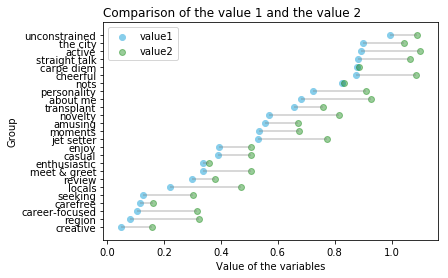

In [83]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
 
# Create a dataframe
value1=np.random.uniform(size=25)
value2=value1+np.random.uniform(size=25)/4
df = pd.DataFrame({'group':topic_labels, 'value1':value1 , 'value2':value2 })
 
# Reorder it following the values of the first value:
ordered_df = df.sort_values(by='value1')
my_range=range(1,len(df.index)+1)
 group
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=ordered_df['value1'], xmax=ordered_df['value2'], color='grey', alpha=0.4)
plt.scatter(ordered_df['value1'], my_range, color='skyblue', alpha=1, label='value1')
plt.scatter(ordered_df['value2'], my_range, color='green', alpha=0.4 , label='value2')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['group'])
plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xlabel('Value of the variables')
plt.ylabel('Group')

In [49]:
from utils.text_representation import feature_vectors

In [51]:
essay_list = ['essay0', 'essay4']
df_0, df_9 = clean_up(df, essay_list)

df_0 = recategorize(df_0)
df_9 = recategorize(df_9)

In [ ]:
labels = ['meet & greet', 'the city', 'enthusiastic', 'straight talk', 'about me', 'novelty',
          'seeking', 'carefree', 'casual', 'enjoy', 'transplant', 'nots', 'moments',
          'personality', 'amusing', 'review', 'region', 'career-focused', 'locals',
          'unconstrained', 'active', 'creative', 'carpe diem', 'cheerful', 'jet setter']

In [53]:
specs = {'stop_words' : 'english', 'ngram_range' : (1, 3), 'min_df' : 0.005}
counts, tfidf, vocab = feature_vectors(df_0.essay0, specs)
df_0['group'] = nmf_labels(tfidf, k=K)

KeyboardInterrupt: 

In [ ]:
demog = 'height'
subset = subset_df(df_0, demog, ['short', 'not short'])
grouped = group_pct(subset, demog)
lollipop_paper(grouped, demog, topic_labels=labels)